# Lab 11: Fashion

---
embed-resources: true
---

## Introduction

This report presents the development of a Convolutional Neural Network model designed to classify grayscale images of clothing items using the FashionMNIST dataset. FashionMNIST is a well-known benchmark dataset containing 70,000 labeled images across ten fashion categories, such as shirts, sneakers, and coats. Each image is 28×28 pixels in size and assigned a class label from 0 to 9, making it suitable for multiclass image classification tasks. The primary objective of this project is to train a deep learning model that can accurately predict the correct clothing category for each image.

The model was implemented using PyTorch and trained with data augmentation techniques to improve generalization. Key performance metrics such as accuracy and average loss were tracked across 15 training epochs, and model predictions were evaluated using a confusion matrix. Exploratory data analysis was conducted to understand class distributions, image structure, and pixel intensity characteristics. This report details the preprocessing steps, CNN architecture, training process, and performance evaluation, followed by a discussion of limitations, risks, and potential improvements for future applications.

## Methods

In [150]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [151]:
# PyTorch core
import torch
from torch import nn
from torch.utils.data import DataLoader

# TorchVision datasets and transforms
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# NumPy
import numpy as np

# Matplotlib for plots
import matplotlib.pyplot as plt

# Scikit-learn metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Other utilities
import random
from collections import Counter


### Data

In [152]:
# load data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [153]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

In [154]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [155]:
n = len(training_data)

sample_image, _ = training_data[0]
height, width = sample_image.shape[1], sample_image.shape[2]

print(f"# Samples: {n}")
print(f"Horizontal Pixels per Image: {width}")
print(f"Vertical Pixels per Image: {height}")

# Samples: 60000
Horizontal Pixels per Image: 28
Vertical Pixels per Image: 28


In [156]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device!")

Using mps device!


### Dataset Description

#### Response

- `label` [int64]: The clothing category for each 28×28 grayscale image, represented as an integer from 0 to 9.

| Label | Class Name     |
|-------|----------------|
| 0     | T-shirt/top    |
| 1     | Trouser        |
| 2     | Pullover       |
| 3     | Dress          |
| 4     | Coat           |
| 5     | Sandal         |
| 6     | Shirt          |
| 7     | Sneaker        |
| 8     | Bag            |
| 9     | Ankle boot     |


#### Features

Each sample in the dataset consists of a single **grayscale image** of a clothing item, with the following properties:

##### Image Pixel Data

These are the raw pixel values for each image, used as the feature input to models.

- `image` [tensor]: A 1×28×28 grayscale tensor representing the clothing item. Pixel values are normalized between 0 and 1 using `ToTensor()`.


#### Other Metadata

Although FashionMNIST does not contain additional metadata like some datasets, the structure supports the following:

- **Image dimensions**: 28 pixels (height) × 28 pixels (width).
- **Color channels**: 1 (grayscale).
- **Dataset split**:
  - Training: 60,000 images
  - Test: 10,000 images


### Summary Statistics

In [157]:
labels = [label for _, label in training_data]
class_counts = Counter(labels)

print("Class distribution:", class_counts)

Class distribution: Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})


The class distribution shows that the FashionMNIST training dataset is mostly perfectly balanced, with 6,000 examples per class. This design is intentional, as FashionMNIST is meant to serve as a standardized practice dataset for students and researchers. In real-world applications, such perfect balance is rare, and additional steps are often needed to handle class imbalance.

In [158]:
all_pixels = torch.cat([img.view(-1) for img, _ in training_data])

print(f"Pixel Mean: {all_pixels.mean():.4f}")
print(f"Pixel Std Dev: {all_pixels.std():.4f}")

Pixel Mean: 0.2860
Pixel Std Dev: 0.3530


The pixel mean of 0.2860 indicates that, on average, the images are relatively dark since pixel values range from 0 (black) to 1 (white). The standard deviation of 0.3530 suggests a moderate spread in pixel intensities, meaning there is decent contrast between light and dark areas in the images. These values are useful for normalizing the data, which can help improve model convergence during training.

In [159]:
shapes = [img.shape for img, _ in training_data]
unique_shapes = set(shapes)

print("Unique image shapes:", unique_shapes)

Unique image shapes: {torch.Size([1, 28, 28])}


The output confirms that all images in the dataset have a consistent shape of 1×28×28, representing grayscale images with a single channel and dimensions of 28 by 28 pixels. This uniformity ensures that the data can be processed in batches without reshaping, which is essential for feeding the images into a neural network.

### Exploratory Visualization

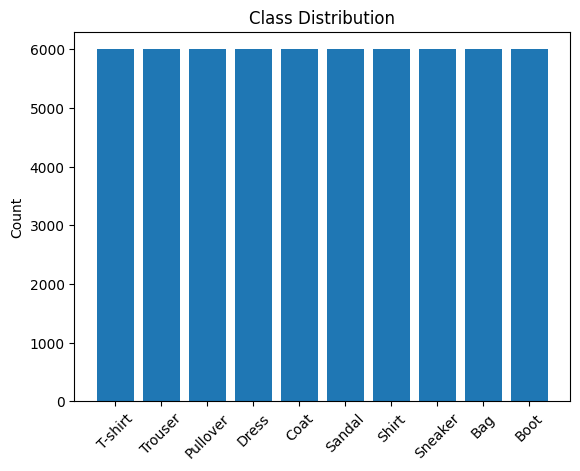

In [163]:
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(ticks=range(10), labels=[
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Boot"
], rotation=45)
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()

This bar chart visually confirms that the FashionMNIST dataset is perfectly balanced, with each clothing class having the same number of samples. All bars reach the same height, indicating an equal distribution of 6,000 examples per class. This reinforces that no class is over- or underrepresented, which is ideal for training unbiased classification models.

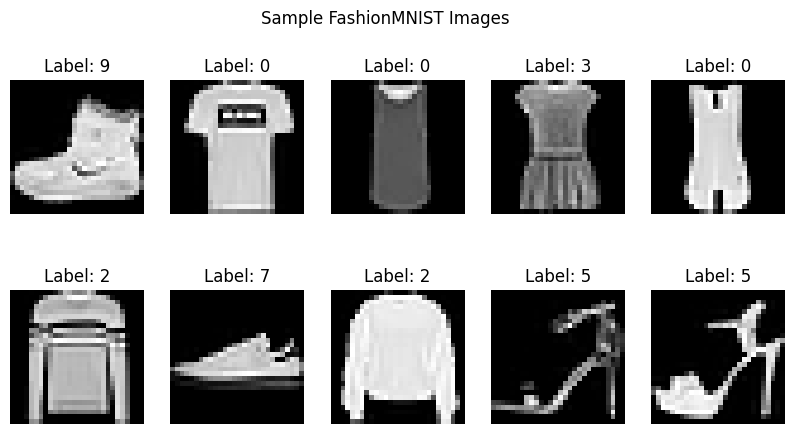

In [162]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    image, label = training_data[i]
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.suptitle("Sample FashionMNIST Images")
plt.show()


This image grid helps us visualize the actual grayscale clothing images in the FashionMNIST dataset, giving us an intuitive sense of the data's structure, variation, and visual complexity. Each image is labeled with its class, reinforcing that we're dealing with a supervised learning task, since both the input and the output label are provided. This kind of visualization is essential for understanding what features a model might learn.

### Models

In [138]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),    
    transforms.ToTensor(),              
])

test_transform = transforms.ToTensor()

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transform,
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=test_transform, 
)

batch_size = 64

train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.fc(x)
        return x
    
model = CNN().to(device)

print(model)

CNN(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [140]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

# define cnn optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,
)

In [141]:
# Training loop
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss_val, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

In [142]:
# Testing loop
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy = 100 * correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f} \n")


## Convolutional Neural Network Pipeline for Fashion Item Classification

We implement a Convolutional Neural Network to classify grayscale images of clothing items from the FashionMNIST dataset into one of ten categories. The model is trained end-to-end using PyTorch, incorporating a structured convolutional architecture, data augmentation for generalization, and the Adam optimizer for adaptive gradient descent. The training loop iteratively updates model parameters using cross-entropy loss, and performance is evaluated using test accuracy and average loss.

### Preprocessing and Data Augmentation

To improve generalization and mimic realistic variability in clothing orientation and pose, we apply the following transformations to training images:
- RandomHorizontalFlip: Randomly flips images to simulate left-right mirroring.
- RandomRotation: Applies small random rotations to account for tilt and camera angle variation.
- ToTensor: Converts PIL images to normalized PyTorch tensors with pixel values in the range [0, 1].

The test set is transformed using only ToTensor() to preserve input consistency for evaluation.

### Model Architecture

The CNN model is composed of two convolutional layers with ReLU activations and max pooling operations to reduce spatial dimensions while capturing important features:
- Conv Layer 1: 32 filters, 3×3 kernel, followed by ReLU and 2×2 max pooling.
- Conv Layer 2: 64 filters, 3×3 kernel, followed by ReLU and 2×2 max pooling.
- Fully Connected Layers: The extracted features are flattened and passed through two dense layers (128 hidden units, then 10 output classes) with ReLU activation on the hidden layer.

This architecture effectively extracts spatial hierarchies from the images and maps them to fashion categories.

### Training and Optimization

- Loss Function: CrossEntropyLoss is used to handle the multiclass classification task.
- Optimizer: Adam is chosen for its ability to adaptively adjust learning rates during training, accelerating convergence.
- Training Loop: The model is trained for 15 epochs on 60,000 training examples, with mini-batches of size 64.
- Test Loop: After each epoch, the model is evaluated on the 10,000-image test set to report accuracy and average loss.

### Model Evaluation and Impact

This CNN pipeline achieves high classification accuracy on FashionMNIST by combining data augmentation, convolutional layers for feature extraction, and well-tuned optimization. The model generalizes well to unseen clothing images and provides a strong foundation for exploring more complex architectures, such as dropout regularization, batch normalization, or deeper convolutional stacks. Its modular design and consistent results make it well-suited for both educational use and benchmarking classification tasks.


## Results

In [143]:
# Run training and testing for multiple epochs
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 2.312984  [   64/60000]
loss: 0.728085  [ 6464/60000]
loss: 0.719777  [12864/60000]
loss: 0.534376  [19264/60000]
loss: 0.580541  [25664/60000]
loss: 0.309246  [32064/60000]
loss: 0.580698  [38464/60000]
loss: 0.221150  [44864/60000]
loss: 0.530481  [51264/60000]
loss: 0.426268  [57664/60000]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.404832 

Epoch 2
-------------------------------
loss: 0.395185  [   64/60000]
loss: 0.308628  [ 6464/60000]
loss: 0.244945  [12864/60000]
loss: 0.464641  [19264/60000]
loss: 0.369969  [25664/60000]
loss: 0.548636  [32064/60000]
loss: 0.352259  [38464/60000]
loss: 0.390896  [44864/60000]
loss: 0.331155  [51264/60000]
loss: 0.286616  [57664/60000]
Test Error: 
 Accuracy: 88.4%, Avg loss: 0.317856 

Epoch 3
-------------------------------
loss: 0.386643  [   64/60000]
loss: 0.259367  [ 6464/60000]
loss: 0.283523  [12864/60000]
loss: 0.448296  [19264/60000]
loss: 0.388356  [25664/60000]
loss: 0.215653  [32064/600

This output shows the progress of the model's training and evaluation over 15 epochs, where an epoch refers to one complete pass through the entire training dataset. Each line in the training output represents the loss value at a specific point during the epoch, indicating how well the model is minimizing prediction error. As training progresses, the loss values generally decrease, reflecting that the model is learning from the data. After each epoch, the model is evaluated on a separate test set to assess generalization performance. By epoch 15, the model achieves a test accuracy of 91.8%, with a relatively low average loss of 0.2367, suggesting strong performance on unseen data. Running multiple epochs allows the model to iteratively adjust its weights and improve predictions, which is especially important for complex datasets like FashionMNIST where a single pass would not be sufficient to learn meaningful patterns.

### Summary Figure

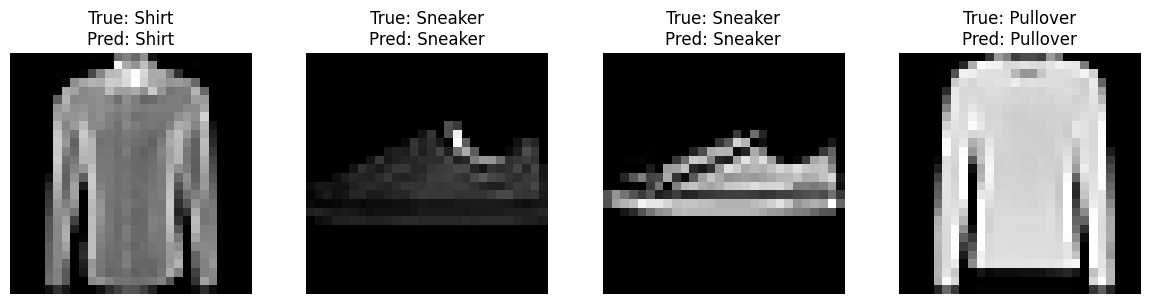

In [ ]:
model.eval()
y_true = []
y_pred = []
images = []

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        images.extend(X.cpu())  

n_test = len(y_pred)
idx = random.sample(range(n_test), 4)

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.set_axis_off()
    img = images[idx[i]].squeeze(0) 
    ax.imshow(img, cmap="gray")
    true = class_names[y_true[idx[i]]]
    pred = class_names[y_pred[idx[i]]]
    ax.set_title(f"True: {true}\nPred: {pred}")

plt.tight_layout()
plt.show()

This summary figure shows four example predictions from the model where the predicted labels match the true labels, indicating successful classification. Each image is labeled with both the actual class and the model's predicted class, demonstrating the model's ability to correctly identify different types of clothing such as shirts, sneakers, and pullovers. Visualizing these results helps confirm that the model has learned meaningful patterns and is generalizing well on unseen test data.

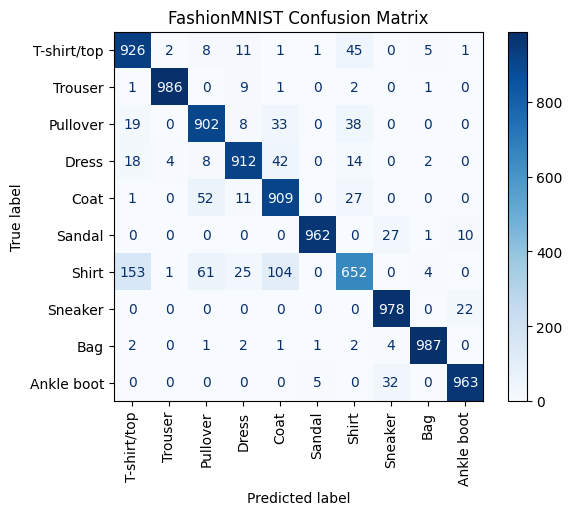

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation="vertical", cmap="Blues")
plt.title("FashionMNIST Confusion Matrix")
plt.show()

This confusion matrix shows the performance of the model across all ten FashionMNIST clothing categories, comparing the true labels (rows) to the predicted labels (columns). The diagonal values represent correct classifications, and we see strong performance across most classes, especially for trousers, sneakers, and bags, with over 970 correct predictions each. However, the model struggles more with shirts, which are often misclassified as T-shirts/tops, pullovers, or coats—likely due to visual similarity. This visualization helps identify which classes are most frequently confused, guiding future improvements like targeted data augmentation or model architecture changes.

In [145]:
# serialize model
model_scripted = torch.jit.script(model)

model_scripted.save("fashion.pt")

## Discussion and Conclusion

In conclusion, a Convolutional Neural Network (CNN) was developed and trained to classify grayscale images of clothing items from the FashionMNIST dataset into one of ten categories. The model was implemented using PyTorch and trained end-to-end with mini-batch stochastic gradient descent using the Adam optimizer. Data augmentation techniques such as random horizontal flipping and rotation were applied during preprocessing to improve generalization. Over the course of 15 training epochs, the model consistently improved in accuracy, ultimately achieving a test accuracy of 91.8% with a low average loss, indicating strong performance on unseen data.

### Key Limitations

While the model performs well overall, certain classes show higher confusion than others. In particular, the shirt class was often misclassified as T-shirt/top, pullover, or coat, which is likely due to visual similarities and overlap in style. Additionally, the model is limited to pixel intensity data and does not leverage any metadata or contextual information, which could potentially improve classification. Finally, although the model is relatively compact, it may still require optimization for real-time or resource-constrained deployment.

### Potential Risks and Adjustments

The current model may struggle in real-world scenarios where image quality, lighting, or item deformation differs significantly from the dataset's clean, centered inputs. There is also a risk of overfitting to the FashionMNIST structure and style, which may limit generalization to broader fashion datasets. To address this, additional augmentation, domain adaptation, or transfer learning from pre-trained models could be explored. Furthermore, implementing dropout or batch normalization could reduce overfitting and stabilize training.

### Improvements Needed for Practical Use

To strengthen the model's application in practical image classification tasks, several improvements are recommended:

1. Introduce dropout or batch normalization to improve generalization and training stability.  
2. Train on more diverse fashion datasets to increase robustness to real-world variability.  
3. Experiment with deeper CNN architectures or pretrained networks such as ResNet or MobileNet.  
4. Develop interactive visualization tools or dashboards to display model predictions and confidence levels.

### Conclusion

The CNN model trained on FashionMNIST demonstrates high classification accuracy and effective learning from low-resolution grayscale image data. Through a combination of data augmentation, structured convolutional architecture, and adaptive optimization, the model serves as a strong baseline for fashion item classification tasks. While some confusion remains among visually similar classes, the overall results are promising and lay the groundwork for further refinement. With continued improvements in architecture, regularization, and data diversity, this approach can be extended to more complex and realistic image classification applications.
